## DrivenData Competition

<b>Team</b>: Adam Fenyvesi, Alban de Raemy, Gustavo A. Trigos, Nicola-Marie Noritz, Yağız Yaver Çiçek

<b>Competition</b>: Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines

<b>Link of Competition</b>: <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/">Click Here</a>

<b>Objective</b>: Your goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, you'll be predicting two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

Each row in the dataset represents one person who responded to the National 2009 H1N1 Flu Survey. 

## Libraries

In [1]:
import time
# Start time including loading the libraries
start = time.time()

In [2]:
# Data exploration and manipulation essentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

# Statistic tests
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor # Calculating VIF

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Classification Models
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Cross-validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer  

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# Misc
import gender_guesser.detector as gender

In [3]:
#Setting display options
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',500)

In [4]:
# setting random seed
rand.seed(a = 7)

## Loading Data

In [5]:
# Loading the dataset
train_features = pd.read_csv('./datasets/Training_Features.csv',index_col=0)
train_labels = pd.read_csv('./datasets/Training_Labels.csv',index_col=0)

test_features = pd.read_csv('./datasets/Test_Features.csv',index_col=0)

In [6]:
# Joining train and test features
df = pd.concat([train_features,test_features])
#P.S. Look into median imputation for test_features

In [7]:
#Marking columns by attributes
cont_columns = [31,32]
interval_columns = [0,1,15,16,17,18,19,20]
categorical_columns = [21,22,23,24,25,26,27,28,29,30,33,34]
logical_columns = [2,3,4,5,6,7,8,9,10,11,12,13,14]

#Inspecting Categorical Variables
# fig , ax = fig, ax = plt.subplots(figsize = (10,50 ))
# plot_index = 1
# for i in categorical_columns:
#     plt.subplot(12,1,plot_index)
#     plt.ylabel(ylabel = df.columns[i])
#     plt.xlabel(xlabel = 'Value Counts')
#     temp_df = df.iloc[:,i].value_counts()
#     temp_plt = temp_df.plot.barh()
#     plot_index += 1
# plt.show()

## Data Preprocessing

### Missing Values

In [8]:
# Looking into columns with any missing values
df.isna().mean()[df.isna().sum() > 0] 

h1n1_concern                   0.003314
h1n1_knowledge                 0.004456
behavioral_antiviral_meds      0.002808
behavioral_avoidance           0.007882
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001535
behavioral_large_gatherings    0.002977
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080876
doctor_recc_seasonal           0.080876
chronic_med_condition          0.035627
child_under_6_months           0.030572
health_worker                  0.029823
health_insurance               0.458710
opinion_h1n1_vacc_effective    0.014771
opinion_h1n1_risk              0.014378
opinion_h1n1_sick_from_vacc    0.014415
opinion_seas_vacc_effective    0.017111
opinion_seas_risk              0.018965
opinion_seas_sick_from_vacc    0.019807
education                      0.052682
income_poverty                 0.166994
marital_status                 0.053356
rent_or_own                    0.076346


In [9]:
#Flagging missing cells
for col in train_features:
    if df[col].isna().astype(int).sum() > 0:
        df['m_'+col] = df[col].isna().astype(int)
        
        if col in df.select_dtypes(exclude = 'object').columns.values:
            # imputation with median
            df[col].fillna(df[col].median(),inplace=True)

### Splitting Data into Numerical Data and Categorical

In [10]:
# Select all features excluding 'object' or categorical data
df_num = df.select_dtypes(exclude = 'object').copy()
df_cat = df.select_dtypes(include = 'object').copy()

In [11]:
# Isolating Y-variable from main analysis (choose between h1n1_vaccine or seasonal_vaccine)
response_var_1 = 'h1n1_vaccine'
response_var_2 = 'seasonal_vaccine'
df_response = train_labels

### Exploring Response Variable's proportions

In [12]:
# Response variable proportion breakdown
(df_response[response_var_1].value_counts() / df_response[response_var_1].shape[0]).round(decimals = 2)

0    0.79
1    0.21
Name: h1n1_vaccine, dtype: float64

In [13]:
(df_response[response_var_2].value_counts() / df_response[response_var_2].shape[0]).round(decimals = 2)

0    0.53
1    0.47
Name: seasonal_vaccine, dtype: float64

## Numerical Data

### Correlation with dependent and independent variables

In [14]:
# Correlation between dependent variable and independent variables
response_corr_1 = df_num.join(df_response).corr()[[response_var_1]].sort_values(by=response_var_1,ascending=False).round(decimals=4)
response_corr_2 = df_num.join(df_response).corr()[[response_var_2]].sort_values(by=response_var_2,ascending=False).round(decimals=4)

In [15]:
response_corr_1.join(response_corr_2)

h1n1_vaccine  seasonal_vaccine
h1n1_vaccine                         1.0000            0.3771
doctor_recc_h1n1                     0.3941            0.1986
seasonal_vaccine                     0.3771            1.0000
opinion_h1n1_risk                    0.3206            0.2157
opinion_h1n1_vacc_effective          0.2674            0.2032
opinion_seas_risk                    0.2559            0.3869
doctor_recc_seasonal                 0.2190            0.3607
opinion_seas_vacc_effective          0.1778            0.3589
health_worker                        0.1681            0.1270
h1n1_concern                         0.1216            0.1545
h1n1_knowledge                       0.1178            0.1198
chronic_med_condition                0.0944            0.1695
opinion_h1n1_sick_from_vacc          0.0746            0.0280
behavioral_wash_hands                0.0746            0.1123
behavioral_touch_face                0.0709            0.1199
behavioral_face_mask                 0.0704            0.0500
child_under_6_months                 0.0667            0.0134
behavioral_avoidance                 0.0468            0.0761
health_insurance                     0.0419            0.1249
behavioral_antiviral_meds            0.0402            0.0060
m_behavioral_antiviral_meds          0.0247            0.0218
behavioral_outside_home              0.0221            0.0533
behavioral_large_gatherings          0.0181            0.0637
opinion_seas_sick_from_vacc          0.0084           -0.0605
household_adults                     0.0073           -0.0651
m_behavioral_face_mask               0.0067            0.0061
m_opinion_h1n1_risk                  0.0027           -0.0211
m_opinion_h1n1_sick_from_vacc       -0.0022           -0.0242
household_children                  -0.0026           -0.1117
m_h1n1_knowledge                    -0.0037            0.0023
m_opinion_seas_vacc_effective       -0.0043           -0.0219
m_behavioral_wash_hands             -0.0044           -0.0029
m_opinion_seas_risk                 -0.0048           -0.0209
m_opinion_h1n1_vacc_effective       -0.0054           -0.0213
m_h1n1_concern                      -0.0055           -0.0011
m_behavioral_large_gatherings       -0.0072            0.0033
m_employment_occupation             -0.0087            0.0865
m_behavioral_outside_home           -0.0090            0.0025
m_opinion_seas_sick_from_vacc       -0.0105           -0.0289
m_employment_industry               -0.0112            0.0850
m_behavioral_avoidance              -0.0117            0.0027
m_chronic_med_condition             -0.0119           -0.0297
m_behavioral_touch_face             -0.0122            0.0026
m_rent_or_own                       -0.0130           -0.0268
m_household_adults                  -0.0132           -0.0406
m_household_children                -0.0132           -0.0406
m_health_worker                     -0.0144           -0.0291
m_child_under_6_months              -0.0144           -0.0291
m_education                         -0.0155           -0.0380
m_employment_status                 -0.0160           -0.0377
m_marital_status                    -0.0177           -0.0361
m_income_poverty                    -0.0255           -0.0154
m_doctor_recc_seasonal              -0.0920           -0.0674
m_doctor_recc_h1n1                  -0.0920           -0.0674
m_health_insurance                  -0.2248           -0.0766

<AxesSubplot:>

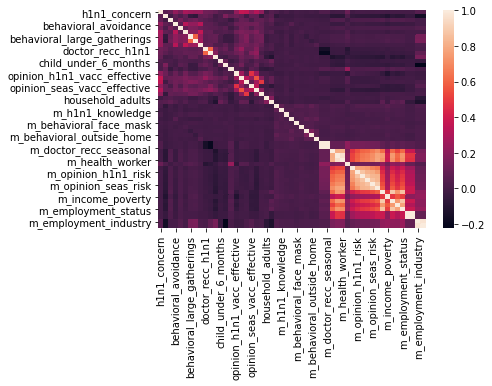

In [16]:
# Correlation Matrix Heatmap
sns.heatmap(df_num.corr())

### Transformation

In [17]:
# # Transform data to log transform
# log_cols = df_num.columns 

# # Creating new columns with new log prefix and natural logarithm transformation.
# for col in log_cols:
#     # Adding constant 1 to avoid transforming log of zero
#     df_num.loc[:,'log_'+col] = np.log(df_num[col]+1)

In [18]:
# # Dropping original values after being transformed
# df_num.drop(log_cols,axis=1,inplace=True)

## Categorical Data

In [19]:
# Subsetting observations from numerical data 
df_cat = df_cat.loc[df_num.index]

In [20]:
# Looking into columns with any missing values
df.iloc[:,categorical_columns].isna().mean()[df.isna().mean() > 0.1] 

income_poverty           0.166994
employment_industry      0.498081
employment_occupation    0.503529
dtype: float64

In [21]:
#Marking significant unknown cells
df_cat['income_poverty'].fillna('unknown_income',inplace=True)
df_cat['employment_industry'].fillna('unknown_industry',inplace=True)
df_cat['employment_occupation'].fillna('unknown_occupation',inplace=True)

In [22]:
categorical_missing_vals = df_cat.loc[:,(df_cat.isna().sum() > 0)].columns

for col in categorical_missing_vals:
    df_cat[col].fillna(df_cat[col].mode().values[0], inplace= True)

In [23]:
df_cat.columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation'], dtype='object')

In [24]:
#getting dummies for categorical columns
# one hot encoding categorical variables
one_hot_age_group       = pd.get_dummies(df_cat['age_group'])
one_hot_education       = pd.get_dummies(df_cat['education'])
one_hot_race            = pd.get_dummies(df_cat['race'])
one_hot_sex             = pd.get_dummies(df_cat['sex'])
one_hot_income          = pd.get_dummies(df_cat['income_poverty'])
one_hot_marital         = pd.get_dummies(df_cat['marital_status'])
one_hot_rent            = pd.get_dummies(df_cat['rent_or_own'])
one_hot_employment      = pd.get_dummies(df_cat['employment_status'])
one_hot_georegion       = pd.get_dummies(df_cat['hhs_geo_region'])
one_hot_census          = pd.get_dummies(df_cat['census_msa'])
one_hot_industry        = pd.get_dummies(df_cat['employment_industry'])
one_hot_occupation      = pd.get_dummies(df_cat['employment_occupation'])


# dropping categorical variables after they've been encoded
df_cat = df_cat.drop('age_group', axis = 1)
df_cat = df_cat.drop('education', axis = 1)
df_cat = df_cat.drop('race', axis = 1)
df_cat = df_cat.drop('sex', axis = 1)
df_cat = df_cat.drop('income_poverty', axis = 1)
df_cat = df_cat.drop('marital_status', axis = 1)
df_cat = df_cat.drop('rent_or_own', axis = 1)
df_cat = df_cat.drop('employment_status', axis = 1)
df_cat = df_cat.drop('hhs_geo_region', axis = 1)
df_cat = df_cat.drop('census_msa', axis = 1)
df_cat = df_cat.drop('employment_industry', axis = 1)
df_cat = df_cat.drop('employment_occupation', axis = 1)


# joining codings together
df_cat= df_cat.join([one_hot_age_group, one_hot_education, one_hot_race, 
                     one_hot_sex, one_hot_income, one_hot_marital,
                     one_hot_rent, one_hot_employment, one_hot_georegion,
                     one_hot_census,one_hot_industry,one_hot_occupation])

df_cat.head(n = 20)

18 - 34 Years  35 - 44 Years  45 - 54 Years  55 - 64 Years  65+ Years  12 Years  < 12 Years  College Graduate  Some College  Black  Hispanic  Other or Multiple  White  Female  Male  <= $75,000, Above Poverty  > $75,000  Below Poverty  unknown_income  Married  Not Married  Own  Rent  Employed  Not in Labor Force  Unemployed  atmpeygn  bhuqouqj  dqpwygqj  fpwskwrf  kbazzjca  lrircsnp  lzgpxyit  mlyzmhmf  oxchjgsf  qufhixun  MSA, Not Principle  City  MSA, Principle City  Non-MSA  \
respondent_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
0                          0              0              0              1          0         0           1                 0             0      0         0                  0      1       1     0                          0          0              1               0        0            1    1     0         0                   1           0         0         0         0         0         0         0         0         0         1         0                         0                    0        1   
1                          0              1              0              0          0         1           0                 0             0      0         0                  0      1       0     1                          0          0              1               0        0            1    0     1         1                   0           0         0         1         0         0         0         0         0         0         0         0                         1                    0        0   
2                          1              0              0              0          0         0           0                 1             0      0         0                  0      1       0     1                          1          0              0               0        0            1    1     0         1                   0           0         0         0         0         0         0         0         0         0         0         1                         1                    0        0   
3                          0              0              0              0          1         1           0                 0             0      0         0                  0      1       1     0                          0          0              1               0        0            1    0     1         0                   1           0         0         0         0         0         0         1         0         0         0         0                         0                    1        0   
4                          0              0              1              0          0         0           0                 0             1      0         0                  0      1       1     0                          1          0              0               0        1            0    1     0         1                   0           0         0         0         0         0         0         0         0         0         0         1                         1                    0        0   
5                          0              0              0              0          1         1           0                 0             0      0         0                  0      1       0     1                          1          0              0               0        1            0    1     0         1                   0           0         1         0         0         0         0         0         0         0         0         0                         0                    1        0   
6                      

In [25]:
# Correlation between dependent variable and independent variables
response_corr_cat_1 = df_cat.join(df_response).corr()[[response_var_1]].sort_values(by=response_var_1,ascending=False).round(decimals=4)
response_corr_cat_2 = df_cat.join(df_response).corr()[[response_var_2]].sort_values(by=response_var_2,ascending=False).round(decimals=4)

In [26]:
response_corr_cat_1.join(response_corr_cat_2)

h1n1_vaccine  seasonal_vaccine
h1n1_vaccine                     1.0000            0.3771
seasonal_vaccine                 0.3771            1.0000
fcxhlnwr                         0.1447            0.1104
cmhcxjea                         0.1397            0.0987
haxffmxo                         0.0747            0.0567
dcjcmpih                         0.0747            0.0567
> $75,000                        0.0580            0.0365
College Graduate                 0.0554            0.0530
Married                          0.0452            0.0424
haliazsg                         0.0394            0.0274
bhuqouqj                         0.0390            0.0214
55 - 64 Years                    0.0381            0.0469
Own                              0.0310            0.1018
White                            0.0309            0.1003
wxleyezf                         0.0218           -0.0063
Female                           0.0207            0.0771
65+ Years                        0.0204            0.2448
oxchjgsf                         0.0156            0.0019
bxpfxfdn                         0.0155           -0.0028
dlvbwzss                         0.0147           -0.0079
mlyzmhmf                         0.0134           -0.0098
Not in Labor Force               0.0131            0.1458
emcorrxb                         0.0130           -0.0040
arjwrbjb                         0.0118           -0.0019
qufhixun                         0.0088            0.0020
hodpvpew                         0.0081           -0.0024
atmpeygn                         0.0035            0.0157
Other or Multiple                0.0025           -0.0232
MSA, Principle City              0.0021           -0.0154
qnlwzans                         0.0010            0.0032
Employed                         0.0004           -0.1070
Non-MSA                         -0.0007           -0.0090
MSA, Not Principle  City        -0.0013            0.0223
lrircsnp                        -0.0015           -0.0304
kldqjyjy                        -0.0018           -0.0191
Hispanic                        -0.0029           -0.0670
xzmlyyjv                        -0.0054            0.0012
xtkaffoo                        -0.0058           -0.0252
phxvnwax                        -0.0062           -0.0136
vlluhbov                        -0.0066           -0.0248
Some College                    -0.0067           -0.0164
ukymxvdu                        -0.0071           -0.0283
oijqvulv                        -0.0074           -0.0221
unknown_occupation              -0.0087            0.0865
fpwskwrf                        -0.0100            0.0064
pvmttkik                        -0.0103           -0.0219
nduyfdeo                        -0.0105           -0.0329
unknown_industry                -0.0112            0.0850
msuufmds                        -0.0112           -0.0008
saaquncn                        -0.0113           -0.0385
kbazzjca                        -0.0119            0.0110
35 - 44 Years                   -0.0147           -0.0848
wlfvacwt                        -0.0171           -0.0135
Below Poverty                   -0.0173           -0.0692
ccgxvspp                        -0.0175           -0.0259
cfqqtusy                        -0.0184           -0.0228
mfikgejo                        -0.0186           -0.0090
mcubkhph                        -0.0194           -0.0335
tfqavkke                        -0.0202           -0.0450
Male                            -0.0207           -0.0771
dqpwygqj                        -0.0211           -0.0132
<= $75,000, Above Poverty       -0.0212            0.0213
mxkfnird                        -0.0212           -0.0145
45 - 54 Years                   -0.0214           -0.0637
ldnlellj                        -0.0216           -0.0373
hfxkjkmi                        -0.0218           -0.0129
dotnnunm                        -0.0219           -0.0196
xqwwgdyp                        -0.0233           -0.0370
rucpziij                 

## Feature Engineering

In [27]:
# Joining number data with categorical data, then separating features from the target value.
df_features = df_cat.join(df_num)

### Domain Knowledge Features

In [28]:
df_features['total_household'] = 1 + df_features['household_adults'] + df_features['household_children']

In [29]:
df_features['child_owner'] = 0

for index, value in df_features.iterrows():
    if df_features.loc[index, 'household_children'] > 0 :
        df_features.loc[index, 'child_owner'] = 1
        
df_features['child_owner'].value_counts()

0    37717
1    15698
Name: child_owner, dtype: int64

In [30]:
df_features['overall_h1n1_concern'] = df_features['opinion_h1n1_risk'] + df_features['opinion_h1n1_sick_from_vacc'] + df_features['opinion_h1n1_vacc_effective']
df_features['overall_seas_concern'] = df_features['opinion_seas_risk'] + df_features['opinion_seas_sick_from_vacc'] + df_features['opinion_seas_vacc_effective']
df_features['overall_vacc_concern'] = df_features['overall_h1n1_concern'] + df_features['overall_seas_concern']

In [31]:
# Making sure inf values turn into nan
df_features.replace([np.inf, -np.inf], np.nan,inplace=True)
df_features.fillna(0,inplace=True)

### Interactions

In [32]:
# # Create every possible bivariate combination to be tested for feature engineering
# from itertools import combinations

# interaction_list = df_num.columns

# interactions = list(combinations(interaction_list, 2))

In [33]:
# # Iterate through interaction list to perform linear regression for each possible engineered features
# for interaction in interactions:
#     df_features['{}_{}'.format(interaction[0],interaction[1])] = df_features[interaction[0]] * df_features[interaction[1]]

# df_features.shape

## Normalization

In [34]:
# Normalize data with Min-Max Scaler with a range of 0 to 1
df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_features))
df_norm.set_index(df_num.index, inplace = True)
df_norm.columns = df_features.columns

# Fixing column names
df_norm.columns = df_norm.columns.str.replace(' ','')
df_norm.columns = df_norm.columns.str.replace('-','')
df_norm.columns = df_norm.columns.str.replace('+','')
df_norm.columns = df_norm.columns.str.replace('<','less')
df_norm.columns = df_norm.columns.str.replace('>','more')
df_norm.columns = df_norm.columns.str.replace('=','equal')
df_norm.columns = df_norm.columns.str.replace(',','')
df_norm.columns = df_norm.columns.str.replace('$','')

#IMPORTANT: To prevent any errors in smf.logit column names cannot begin with numbers,
df_norm.add_prefix('col_')

<ipython-input-34-52e7abb9d020>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_norm.columns = df_norm.columns.str.replace('+','')
<ipython-input-34-52e7abb9d020>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_norm.columns = df_norm.columns.str.replace('$','')


col_1834Years  col_3544Years  col_4554Years  col_5564Years  col_65Years  col_12Years  col_less12Years  col_CollegeGraduate  col_SomeCollege  col_Black  col_Hispanic  col_OtherorMultiple  col_White  col_Female  col_Male  col_lessequal75000AbovePoverty  col_more75000  col_BelowPoverty  col_unknown_income  col_Married  col_NotMarried  col_Own  col_Rent  col_Employed  col_NotinLaborForce  col_Unemployed  col_atmpeygn  col_bhuqouqj  col_dqpwygqj  col_fpwskwrf  col_kbazzjca  \
respondent_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
0                        0.0            0.0            0.0            1.0          0.0          0.0              1.0                  0.0              0.0        0.0           0.0                  0.0        1.0         1.0       0.0                             0.0            0.0               1.0                 0.0          0.0             1.0      1.0       0.0           0.0                  1.0             0.0           0.0           0.0           0.0           0.0           0.0   
1                        0.0            1.0            0.0            0.0          0.0          1.0              0.0                  0.0              0.0        0.0           0.0                  0.0        1.0         0.0       1.0                             0.0            0.0               1.0                 0.0          0.0             1.0      0.0       1.0           1.0                  0.0             0.0           0.0           1.0           0.0           0.0           0.0   
2                        1.0            0.0            0.0            0.0          0.0          0.0              0.0                  1.0              0.0        0.0           0.0                  0.0        1.0         0.0       1.0                             1.0            0.0               0.0                 0.0          0.0             1.0      1.0       0.0           1.0                  0.0             0.0           0.0           0.0           0.0           0.0           0.0   
3                        0.0            0.0            0.0            0.0          1.0          1.0              0.0                  0.0              0.0        0.0           0.0                  0.0        1.0         1.0       0.0                             0.0            0.0               1.0                 0.0          0.0             1.0      0.0       1.0           0.0                  1.0             0.0           0.0           0.0           0.0           0.0           0.0   
4                        0.0            0.0            1.0            0.0          0.0          0.0              0.0                  0.0              1.0        0.0           0.0                  0.0        1.0         1.0       0.0                             1.0            0.0               0.0                 0.0          1.0             0.0      1.0       0.0           1.0                  0.0             0.0           0.0           0.0           0.0           0.0           0.0   
...                      ...            ...            ...            ...          ...          ...              ...                  ...              ...        ...           ...                  ...        ...         ...       ...                             ...            ...               ...                 ...          ...             ...      ...       ...           ...                  ...             ...           ...           ...           ...           ...           ...   
53410                    0.0            1.0            0.0            0.0          0.0 

## Train-Test Split

In [35]:
# Dividing dataset into dependent and independent variables
X_original = df_norm.loc[train_features.index]
X_target = df_norm.loc[test_features.index]

y1 = df_response[response_var_1]
y2 = df_response[response_var_2]

###  Feature Selection

In [36]:
# ## Statsmodel VIF multicollinearity

# def VIF_features(X,feature_threshold=50,VIF_threshold=10):
    
#      '''
#      Calculates Variance Inflation Factor to calculate multicollinearity between
#      independent variables.
    
#      Params:
#      feature_threshold = Minimum Number of features to end with
#      VIF_threshold = amount of VIF expected
    
#      '''
    
#      # copy of dataset
#      X_select = X.copy()
    
#      while X_select.shape[1] > feature_threshold:

#          print(f"""DF Shape: {X_select.shape}""")
        
#          # Calculating VIF
#          print('Calculating VIF')
#          vif = pd.DataFrame(index=X_select.columns)
#          vif["VIF"] = [variance_inflation_factor(X_select.values, i) for i in range(X_select.shape[1])]
        
#          # Getting highest VIF
#          VIF_list = vif.sort_values(by='VIF',ascending=False).round(decimals=4)
#          highest_VIF = VIF_list.index[0]
#          highest_VIF_val = VIF_list['VIF'][0]
        
#          # Feature selection
#          print('Testing VIF value')
#          if (highest_VIF_val > VIF_threshold):     
           
#              print("Deleted Feature:",highest_VIF)
#              print("VIF:",highest_VIF_val)
#              print("Model Size:",X_select.shape[1])
#              print("----------------------")
            
#              X_select.drop(highest_VIF,axis=1,inplace=True)
            
#          else:
#              break
    
#      print("Final Number of features selected: ", X_select.shape[1])
    
#      return X_select.columns


In [37]:
# VIF_list = VIF_features(X_original,feature_threshold=120,VIF_threshold=10)
# X_original = X_original[VIF_list]

In [38]:
# # Statsmodel feature selection auto function

# def auto_features(X,y,response_var,feature_threshold=20,sig_threshold=0.15):
    
#     '''
#     Helper function to get the optimal number of features according to logistic regression
#     coefficient p-value. This method uses bacckward stepwise selection by taking an insignificant coefficient
#     one at a time. 
    
#     Params:
#     feature_threshold = Minimum Number of features to end with
#     sig_threshold = statistical significance threshold
    
#     '''
    
#     # copy of dataset
#     X_select, y_select = X.copy(), y.copy()
    
#     highest_p_val = 'unassigned'
    
#     while X_select.shape[1] > feature_threshold:

#         # Splitting the dataset into 75% Trainning and 25% Testing sets
#         X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, 
#                                                             test_size = 0.20, 
#                                                             random_state = 7, 
#                                                             stratify=y_select)

#         # Instantiating Statsmodel OLS Linear Regression model
#         variables = " + ".join(X_train.columns)
#         formula = '{} ~ '.format(response_var) + variables
        
#         stats_logit = smf.logit(formula = formula,data = X_train.join(y_train))
#         print('Running logistic model')
#         # telling Python to FIT the data to the blueprint
#         results = stats_logit.fit(disp=0)

#         # Looking at highest p-value
#         p_list = results.pvalues.sort_values(ascending=False).round(decimals=4)
#         highest_p = p_list.index[0]
#         highest_p_val = p_list.round(decimals=4)[0]
        
#         # calculating performance
#         model_fit = results
        
#         # PREDICTING on new data
#         model_pred = model_fit.predict(X_test)

#         # ROC-AUC score  (test score)
#         auc_score = roc_auc_score(y_test,model_pred).round(decimals = 4)

#         # Feature selection
#         if (highest_p_val > sig_threshold) and (highest_p != 'Intercept'):            
#             X_select.drop(highest_p,axis=1,inplace=True)
            
#             print("Deleted Feature:",highest_p)
#             print("P-value:",highest_p_val)
#             print("AUC score:", auc_score)
#             print("Model Size:",X_select.shape[1])
#             print("----------------------")
        
#         else:
#             break
    
#     print("Final Number of features selected: ", X_select.shape[1])
#     print("Highest P-value: ", highest_p_val)
    
#     return X_select.columns

In [39]:
# Utilizing Statsmodel Logistic Regression coefficient statistical significance
#significant_list_1 = auto_features(X_original,y1,response_var_1,feature_threshold=60,sig_threshold=0.05)

# Selecting significant features only
X1 = X_original#[significant_list_1]

In [40]:
# Utilizing Statsmodel Logistic Regression coefficient statistical significance
#significant_list_2 = auto_features(X_original,y2,response_var_2,feature_threshold=80,sig_threshold=0.05)

# Selecting significant features only
X2 = X_original#[significant_list_2]

## Machine Learning Process Pipeline

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, roc_auc_score

In [61]:
numeric_cols = X_original.columns[X_original.dtypes != "object"].values

# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

estimators = MultiOutputClassifier(
    estimator=GradientBoostingClassifier(n_estimators= 170, max_leaf_nodes= 26 , max_depth= 8)
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])


X_train, X_eval, y_train, y_eval = train_test_split(
    X_original,
    df_response,
    test_size=0.33,
    shuffle=True,
    stratify=df_response,
    random_state= 7
)

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds


y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


h1n1_vaccine  seasonal_vaccine
respondent_id                                
6012               0.965548          0.964526
13580              0.043123          0.817350
23267              0.024419          0.084628
13110              0.217636          0.122700
967                0.321516          0.863655

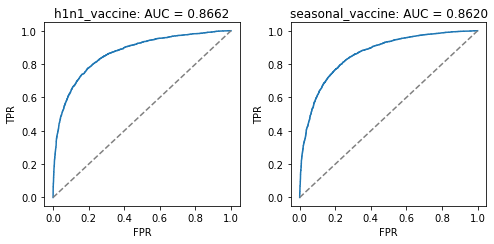

In [62]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )
    
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [63]:
#Rerun with the full dataset
full_pipeline.fit(X_original, df_response)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_target)
preds


y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = X_target.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.111541          0.226770
26708              0.030849          0.045412
26709              0.128889          0.683720
26710              0.705613          0.896768
26711              0.239341          0.496239

In [64]:
submission_df = pd.read_csv("/Users/yagizyavercicek/Desktop/Future Mindset - Competitions/Flu Shot/ml-competition/datasets/submission_format.csv", 
                            index_col="respondent_id")

# Make sure we have the rows in the same order
np.testing.assert_array_equal(X_target.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = preds[0][:, 1]
submission_df["seasonal_vaccine"] = preds[1][:, 1]

submission_df.head()

h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.111541          0.226770
26708              0.030849          0.045412
26709              0.128889          0.683720
26710              0.705613          0.896768
26711              0.239341          0.496239

In [65]:
submission_df.to_csv('my_submission.csv', index=True)

In [ ]:
# Number of Seconds to run the script
end = time.time()
print("Time in Seconds:", round(end - start,2))